## Lab 6: Character Recurrent Neural Nets (char rnn)

### Install



In [1]:
!pip install torch torchvision matplotlib tqdm numpy unidecode

### Download data

In [2]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz

--2018-10-12 03:12:54--  https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz
Resolving piazza.com (piazza.com)... 34.237.217.71, 52.20.136.189, 34.200.202.18, ...
Connecting to piazza.com (piazza.com)|34.237.217.71|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://d1b10bmlvqabco.cloudfront.net/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz [following]
--2018-10-12 03:12:54--  https://d1b10bmlvqabco.cloudfront.net/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz
Resolving d1b10bmlvqabco.cloudfront.net (d1b10bmlvqabco.cloudfront.net)... 13.32.241.75, 13.32.241.29, 13.32.241.165, ...
Connecting to d1b10bmlvqabco.cloudfront.net (d1b10bmlvqabco.cloudfront.net)|13.32.241.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533290 (1.5M) [application/x-gzip]
Saving to: ‘./text_files.tar.gz’

./text_files.tar.gz 100%[

### Load the data

In [0]:
import unidecode
import string
import random
import re
import torch.nn.functional as F 
import torch.nn as nn 
import pdb
import math
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
%matplotlib inline


all_characters = string.printable
n_characters = len(all_characters)
 
# file = unidecode.unidecode(open('./text_files/lotr.txt').read())
# file_len = len(file)
# print('file_len =', file_len)

### Plot module

In [0]:
def plotloss(x, loss):
  plt.figure()
  # x = range(len(loss))
  plt.plot(x, loss, label='Training loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Losses per Epoch")
  plt.legend()
  plt.show()



## Load the data



In [0]:
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
     tensor[c] = all_characters.index(string[c])
  return Variable(tensor)
 
def tensor_char(tensor):
  sentence=""
  for t in tensor:
    sentence+=all_characters[t]
  return sentence


class Data:
  def __init__(self, filename='./text_files/lotr.txt', chunk_len=200):
    self.filename = filename
    self.chunk_len = chunk_len
    
  def load_data(self):
    self.file = unidecode.unidecode(open(self.filename).read())
    self.file_len = len(self.file)
    print('file_len =', self.file_len)
    return self.file
  
  def random_chunk(self):
    start_index = random.randint(0, self.file_len - self.chunk_len)
    #start_index = 20013
    end_index = start_index + self.chunk_len + 1
    # string = "If you’re in a bad situation and someone offers to help you, you have to take whatever they give you and shouldn’t ask for more."
    #return string
    return self.file[start_index:end_index]
  
  def random_training_set(self):    
    chunk = self.random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# print(char_tensor('abcDEF'))
# print(char_tensor('The sun had gone down red behind the hills at their backs,'))
"""
chunk_len = 200
 
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    #start_index = 20013
    end_index = start_index + chunk_len + 1
    # string = "If you’re in a bad situation and someone offers to help you, you have to take whatever they give you and shouldn’t ask for more."
    #return string
    return file[start_index:end_index]
 
print(random_chunk())

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)
 
print(char_tensor('abcDEF'))
print(char_tensor('The sun had gone down red behind the hills at their backs,'))

def tensor_char(tensor):
  sentence=""
  for t in tensor:
    sentence+=all_characters[t]
  return sentence

sent = tensor_char([10, 11, 12, 39, 40, 41])
print (sent)

sent = tensor_char([55, 17, 14, 94, 28, 30, 23, 94, 17, 10, 13, 94, 16, 24, 23, 14, 94, 13,
        24, 32, 23, 94, 27, 14, 13, 94, 11, 14, 17, 18, 23, 13, 94, 29, 17, 14,
        94, 17, 18, 21, 21, 28, 94, 10, 29, 94, 29, 17, 14, 18, 27, 94, 11, 10,
        12, 20, 28, 73])
print (sent)

def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target
"""     

### GRU Cell

In [0]:
## Manual definition of GRU
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, n_layer=1, bias=True):
    super(GRU, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = n_layer
    self.bias = bias
    
    gate_size = 1 * hidden_size
    self.w_ir = Parameter(torch.Tensor(gate_size, input_size))
    self.w_iz = Parameter(torch.Tensor(gate_size, hidden_size))
    self.w_in = Parameter(torch.Tensor(gate_size, hidden_size))
    
    self.w_hr = Parameter(torch.Tensor(gate_size, input_size))
    self.w_hz = Parameter(torch.Tensor(gate_size, hidden_size))
    self.w_hn = Parameter(torch.Tensor(gate_size, hidden_size))
    
    self.b_ir = Parameter(torch.Tensor(gate_size))
    self.b_iz = Parameter(torch.Tensor(gate_size))
    self.b_in = Parameter(torch.Tensor(gate_size))
    
    self.b_hr = Parameter(torch.Tensor(gate_size))
    self.b_hz = Parameter(torch.Tensor(gate_size))
    self.b_hn = Parameter(torch.Tensor(gate_size))
    
    # Init the parameters
    std = 1.0 / math.sqrt(hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-std, std)
    
    
  def forward(self, input, hidden):
    # print (self.w_ir.shape, input.shape, self.b_ir.shape)
    r = torch.sigmoid(torch.mm(self.w_ir, input.squeeze(0).t()).view(1,1,-1) + self.b_ir + torch.mm(self.w_hr, hidden.squeeze(0).t()).view(1,1,-1) + self.b_hr)
    #r = torch.sigmoid(self.w_ir * input + self.b_ir + self.w_hr * hidden + self.b_hr)
    #pdb.set_trace()
    #z = torch.sigmoid(self.w_iz * input + self.b_iz + self.w_hz * hidden + self.b_hz)
    z = torch.sigmoid(torch.mm(self.w_iz, input.squeeze(0).t()).view(1,1,-1) + self.b_iz + torch.mm(self.w_hz, hidden.squeeze(0).t()).view(1,1,-1) + self.b_hz)
    #n = torch.tanh(self.w_in * input + self.b_in + r * (self.w_hn* hidden + self.b_hn))
    n = torch.tanh(torch.mm(self.w_in, input.squeeze(0).t()).view(1,1,-1) + self.b_in + r * (torch.mm(self.w_hz, hidden.squeeze(0).t()).view(1,1,-1) + self.b_hz))
    
    #print ('Forward',z.shape, n.shape, hidden.shape)
    h = (1 - z) * n + z * hidden
    return n, h


### Rnn module

In [0]:
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
from torch.nn.parameter import Parameter
import pdb 
  
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
 
 
        # encode using embedding layer
        # set up GRU passing in number of layers parameter (nn.GRU)
        # decode output
        # print ('for embedding', self.output_size, self.hidden_size)
        self.embedding = nn.Embedding(self.hidden_size, self.hidden_size)
        #self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers)
        # Home grown GRU
        self.gru = GRU(self.hidden_size, self.hidden_size, self.n_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
 
    def forward(self, input_char, hidden):
        # by reviewing the documentation, construct a forward function that properly uses the output
        # of the GRU
        # return output and hidden
        # print ('before embedding',input_char.shape)
        embedded = self.embedding(input_char).view(1, 1, -1)
        #print('Before emm',input_char.shape, embedded.shape, hidden.shape)
        output = F.relu(embedded)
        # print ('before gru', output.shape, hidden.shape)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        #print (output.shape, hidden.shape)
        return output, hidden
        
 
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

### Train function

In [0]:
def train(inp, target, chunk_len):
    ## initialize hidden layers, set up gradient and loss 
      # your code here
    ## /
    hidden = decoder.init_hidden()
    decoder_optimizer.zero_grad()
    loss = 0
    for c in range(chunk_len):
        # print('loop', inp.shape, hidden.shape)
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))
 
    ## calculate backwards loss and step the optimizer (globally)
      # your code here
    ## /
    loss.backward()
    decoder_optimizer.step()
 
    return loss.item() / chunk_len

### Evaluate Function

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    ## initialize hidden variable, initialize other useful variables 
      # your code here
    ## /
 
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
 
    predicted = ""
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
      #print(prime_input, prime_input.shape)
      _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
 
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden) #run your RNN/decoder forward on the input
 
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
 
        ## get character from your list of all characters, add it to your output str sequence, set input
        ## for the next pass through the model
         # your code here
        ## /
        #print ('top_i', top_i)
        #predicted.append(top_i.item())
        predicted += tensor_char([top_i.item()])
        inp = top_i
    return predicted

### Training loop

In [0]:
import time

def training(n_epochs=3000, hidden_size=100, filename='./text_files/lotr.txt', chunk_len=200):
  # n_epochs = 3000
  print_every = 100
  plot_every = 10
  # hidden_size = 100
  n_layers = 1
  lr = 0.001

  data = Data(filename, chunk_len)
  data.load_data()

  decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  start = time.time()
  all_losses = []
  loss_avg = 0
  xs = []

  for epoch in range(1, n_epochs + 1):
      # print (epoch)
      loss_ = train(*data.random_training_set() ,data.chunk_len)       
      loss_avg += loss_

      if epoch % print_every == 0:
          print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
          print(evaluate('Dun', data.chunk_len), '\n')

      plot_time = epoch % plot_every
      if plot_time == 0:
          xs.append(epoch)
          all_losses.append(loss_avg / plot_every)

          loss_avg = 0

  plotloss(xs, all_losses)
        
        

### Training the default dataset LOTR

file_len = 2579888
[27.194292783737183 (100 3%) 2.2280]
g pat sesn ther Sirs borss Eowing fowed or theig tored ord to he higo sait 
dwou yon 

ow 
the thins, wiv: or "aret, sanerrey 


'ar aor the in Mond wpot slol tord she orest the the hedes, ther pThe,  

[54.431501626968384 (200 6%) 2.1725]
gs th the y eed the I the and reree thed the arorghir waiy thasek the Te thed. 



co pout seelp, at asast the ferel the sof bere ghenge rithe the boe seton 






anghe 
thr noul sthic oungs cind the 

[81.64273309707642 (300 10%) 2.2800]
gcle the wire norit in change fand Deat yout wild youm mas sowelle ghe 
ullot in said beemneer 

gof of reer she bich bof chas the in earde wisee sow mit wasid me ams the wan of way and tha sirey 
che 

[108.96871447563171 (400 13%) 2.2465]
 his.tho therat of thow thare the he the henceing Ey goen and aid seichts had alle tutk ack, aned heer arigh to tweed themp orst ayondes ling the beand prisheed I wit asting and the mestind wern to to 

[136.16069293022156 

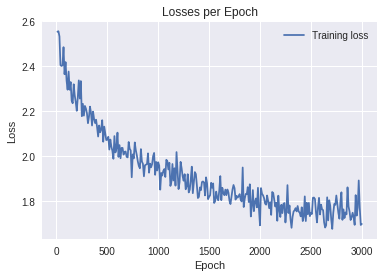

In [29]:
training()

## Training other dataset

### Training Shakespeare dataset

file_len = 1115394
[26.676495790481567 (100 3%) 1.8783]
d mangen it your theze that vie came be bees,
Berast sise year that her to the in the tell swarden them.
What shorthed creat mount 
that the bries and pieser,
And should withwan an then his hasse-thea 

[53.58840298652649 (200 6%) 2.0255]
t
I deec, love, with single, shell whill of shoult to for he shurary,
As say tut-lac, shan that wapperered doce.

IEE?
But with their Varkie-tood I dit our heid had my glass must befint,
Of the soir;
 

[80.27593779563904 (300 10%) 1.9527]
t, is hand,
And song here he cany; his well an you gomath a inding have when be fore or every
Bup hive and to longence ono the blation the barce.
:

ANORLIO:
And the know down in the lives my heal goo 

[107.17437219619751 (400 13%) 1.9591]
ot crysh to know that plaichoss ere black
That the deavess bais my wertes forgond
seltil bode
That be more of Eistire:
And of home and asfalleses, I take the housed, and made will nor welverant uponty 

[133.96132612228394 (

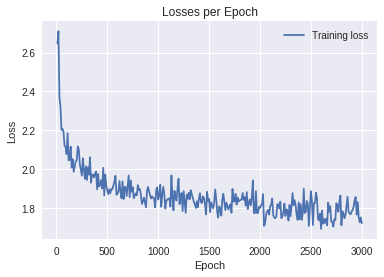

In [31]:
training(filename='text_files/tiny_shakespeare.txt')

### Training alma dataset

file_len = 466656
[25.694056749343872 (100 3%) 1.6443]
her thou wild the petrong, and of the faintered brought and tell debencent and the that a prople away went of the buth that care.

say the witch unto them carwing encreanns to stried in the will tence 

[51.74281144142151 (200 6%) 1.6015]
tel the Gre mand of his are the word stable of do neming a ting or galf unto to be the truent; So my tound, devent he thy prodows the entilly and of its they slay the was the brown seer, and came and  

[77.75945448875427 (300 10%) 1.5740]
ting to the this by Lord of the pato-trockess the have of the with bo the Shall them in they was the pance into ap.

 Beace God and with those were all of the words, and faich that ye with the who the 

[103.85883522033691 (400 13%) 1.4063]
e the chacal the trony out cerest to for men lanks of that be the land of the Narch that the chural, bungers of Ammon the words, of Anted and mather them; this say was begail do pass, and that then se 

[129.6546721458435 (50

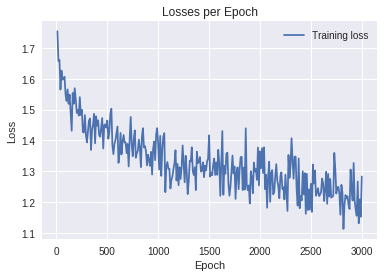

In [32]:
training(filename='text_files/alma.txt')